# **Time Series Forecasting with ARIMA Model**

ARIMA - Auto Regressive Integrated Moving Average

An ARIMA model is characterized by 3 terms: p, d, q
<br><br>
* **AR (p) Autoregression:** An auto regressive AR(p) term refers to the number of lags of Y to be used as predictors.
<br><br>
* **I (d) Integration:** uses differencing of observations (subtracting an observation with an obseervation from the previous step) in order to make the time series stationary.
<br><br>
* **MA (q) Moving Average:**  ‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
<br><br>

Model Types: 

**ARIMA** - Non-seasonal auto regressive integrated moving average

<span style="color:crimson">**ARIMAX** - ARIMA with exogenous variable</span>

**SARIMA** - Seasonal ARIMA

**SARIMAX** - Seasonal ARIMA with exogenous variable

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the dataset. 
# This dataset contains the stock price for 'Apple' and the stock price for 'TXN'
data = pd.read_csv('Apple.csv')
print(data.dtypes)

Date         object
Apple       float64
TexasIns    float64
dtype: object


In [3]:
data.tail()

,Date,Apple,TexasIns
24,2022-01-01,174.78,179.49
25,2022-02-01,165.12,169.99
26,2022-03-01,174.61,183.48
27,2022-04-01,157.65,170.25
28,2022-05-01,148.84,176.76


The column `Date` is an 'object'. We need to change it to `datetime` data type.

In [4]:
# convert 'Date' to datetime type
data['Date'] = pd.to_datetime(data['Date'])


In [5]:
# check the datatype
print(data.dtypes)

Date        datetime64[ns]
Apple              float64
TexasIns           float64
dtype: object


# Univariate - Using only one variable

In [6]:
# Univariate analysis - We will only use 'Apple' variable. 
# Training data - January 2020 to January 2022
# Testing data - February 2022 - May 2022
df = data.iloc[0:25,0:2]

In [7]:
# check the data
df.tail()

,Date,Apple
20,2021-09-01,141.50
21,2021-10-01,149.80
22,2021-11-01,165.30
23,2021-12-01,177.57
24,2022-01-01,174.78


In [8]:
# set the 'Date' column as index
df = df.set_index('Date')

C:\Users\sarah\AppData\Local\Temp\ipykernel_26620\2346836514.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.index, rotation=90)


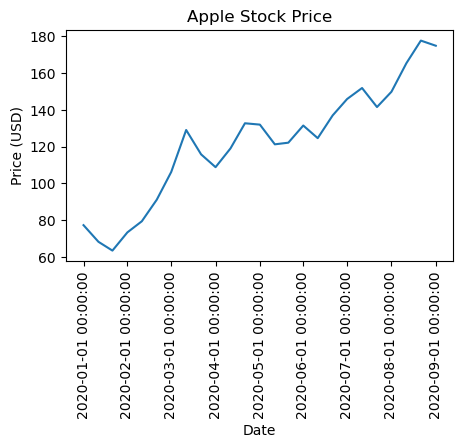

In [9]:
# Plot Apple - Dependent (Target) variable
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(df['Apple'])
ax.set_title('Apple Stock Price')
ax.set_xlabel('Date')
ax.set_xticklabels(df.index, rotation=90)
ax.set_ylabel('Price (USD)')
plt.show()


### Decomposition

In [10]:
# Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['Apple'])

In [11]:
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

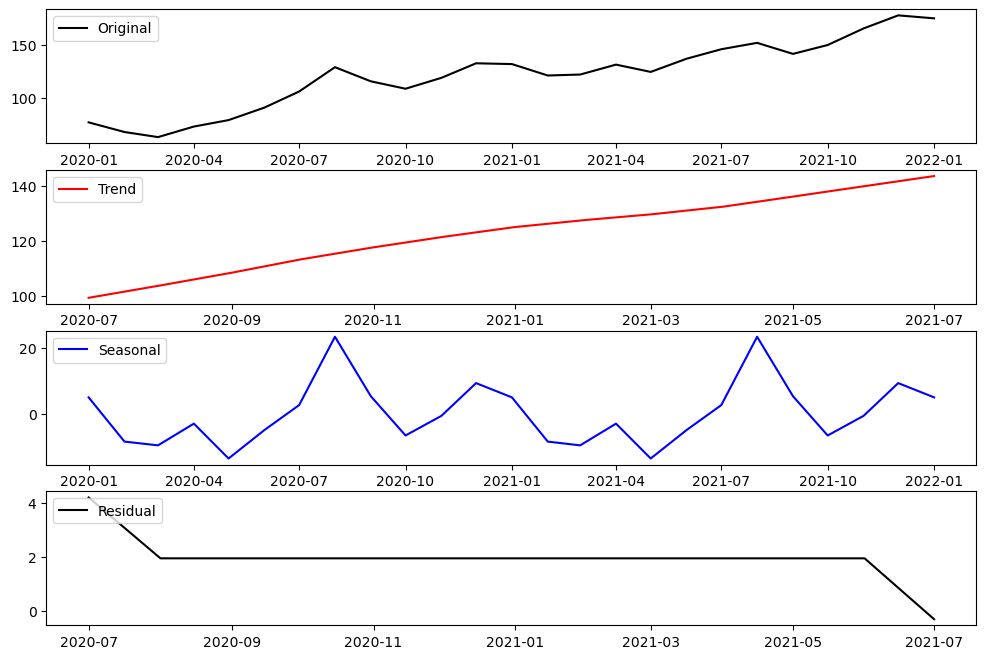

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Apple'], label='Original', color='black')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='black')
plt.legend(loc='upper left')
plt.show()

If the **residual plot** is a straight line at a non-zero value (in this case, 2), it indicates the presence of some systematic bias or pattern in the residuals, which means the model is not accounting for all the information in the data. This could be due to various reasons such as missing variables, incorrect model selection, or a non-linear relationship between the variables.

<https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html>

## **Find p, d, q**

### To find p and q use ACF and PACF plots from statsmodels library

C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


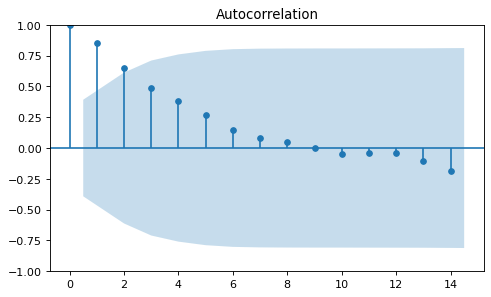

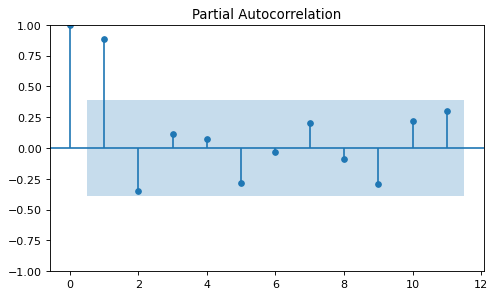

In [13]:
# for finding p,q using PACF and ACF plots respectively
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':80})

# plot ACF 
plot_acf(df['Apple'].dropna());

# plot PACF
plot_pacf(df['Apple'].dropna(), lags=11);

plt.show()

**q** is given by the ACF plot, where you count the number of spikes outside of the confidence interval (blue area). The first one which is 0, is the current value which will always be correlated to itself i.e. value is 1. In this case we only 1 spike outside the confidence interval. Therefore, `q = 1`


**p** is given by the PACF plot, where you count the number of spikes outside of the confidence interval (blue area). The first one which is 0, is the current value which will always be correlated to itself i.e. value is 1. In this case we only have 1 spike outside the confidence interval. Therefore, `p = 1`
That spike value in pacf (i.e. 0.76 are the coeficient values (beta1, beta2, etc.) in the linear regression equation)

We can use `q = 1` and `p = 1`

The key difference between the **Partial Autocorrelation Function (PACF)** and the **Autocorrelation Function (ACF)** is that the **PACF** measures the relationship between a time series and its lagged values after removing the effects of the intervening lags, while the **ACF** measures the relationship between a time series and its lagged values without removing the effects of the intervening lags.

For example, let's say we have a time series of monthly sales data for a store. If we are considering the correlation between sales in January and sales in March, then February is the intervening lag. The effect of the February sales on the correlation between January and March sales is accounted for when we use the PACF, as it controls for the effect of the intervening lags.

### To find d, we have to first check if the series is stationary



The first step to build an ARIMA model is to make the time series stationary.

Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, work best when the predictors are not correlated and are independent of each other.

To make a series stationary, the most common approach is to difference (d) it. The value of `d`, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

In [14]:
# Augmented Dickey-Fuller (ADF) test to check if the data is stationary. We already know it is not by looking at the chart above.
from statsmodels.tsa.stattools import adfuller

In [15]:
# if p value < 0.05 the series is stationary
results = adfuller(df['Apple'])
print('p-value:', results[1]) # adf, pvalue, usedlag_, nobs_, critical_values_, icbest_

p-value: 0.9965327326233812


STEPS:
* First check the p-value. If p-value is <0.05, your series is stationary.
* If not, do a first order differencing
* Perform the ADF test on the differenced series to check the p-value
* If p-value is <0.05, your series is stationary
* If not, do a second order differencing. 
* Whatever order of differencing you do, that will be your value of 'd' in ARIMA model

p-value is 0.99. Therefore, the series is **not stationary**. Therefore, we will need to make it stationary.

### Differencing - To make series stationary

In [16]:
# 1st order differencing
v1 = df['Apple'].diff().dropna()

# adf test on the new series. if p value < 0.05 the series is stationary
results1 = adfuller(v1)
print('p-value:', results1[1]) # adf, pvalue, usedlag_, nobs_, critical_values_, icbest_

p-value: 0.015214001528359977


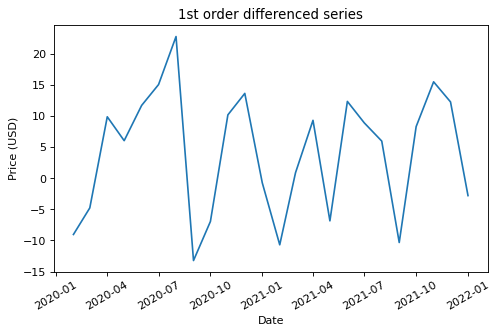

In [17]:
# Plot the differenced series
plt.plot(v1)
plt.title('1st order differenced series')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('Price (USD)')
plt.show()

In [18]:
# the mean for above series is
(v1.values).mean()

4.058333333333334

The right order of differencing is the minimum differencing required to get a near-stationary series.

In [19]:
# if reqired, 2nd order differencing would be
# v2 = v1.diff().dropna()
# results2 = adfuller(v2)
# print('p-value:', results2[1]) # adf, pvalue, usedlag_, nobs_, critical_values_, icbest_

## **Training and Forecasting**

In [20]:
# Use statsmodels 0.11 or later
# to check the version after import use: print(statsmodels.__version__)
# to upgrade use: !pip install statsmodels --upgrade

# Install statsmodel
#!pip install statsmodels==0.13
import statsmodels

In [21]:
# Import ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

In [23]:
# 1,1,1 ARIMA Model
arima = ARIMA(df.Apple, order=(1,1,1))
ar_model = arima.fit()
print(ar_model.summary())

C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Apple   No. Observations:                   25
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -89.725
Date:                Mon, 03 Apr 2023   AIC                            185.450
Time:                        18:36:57   BIC                            188.984
Sample:                    01-01-2020   HQIC                           186.387
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0677      0.653     -0.104      0.917      -1.348       1.213
ma.L1          0.3789      0.683      0.554      0.579      -0.960       1.718
sigma2       102.9968     46.552      2.213      0.0

Notice here the coefficient of the MA.L1 and MA.L2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

Insignificant p-values imply that the autoregressive and moving average terms are not statistically significant and therefore should be removed from the model.

Alternatively, it could mean that the model needs to be refined by including additional variables or using a different order of differencing or a higher order ARIMA model.

It's also possible that the data itself may not be suitable for modeling using an ARIMA model, and a different approach may be needed to model the time series.

In [24]:
# Forecast
forecast = ar_model.get_forecast(4)
ypred = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

In [25]:
# Actual values for Feb 2022 to May 2022
data.Apple[25:].values

array([165.12, 174.61, 157.65, 148.84])

In [26]:
# creating a new Dataframe dp with the prediction values.
Date = pd.Series(['2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01'])
price_actual = pd.Series(data.Apple[25:].values)
price_predicted = pd.Series(ypred.values) 
lower_int = pd.Series(conf_int['lower Apple'].values)
upper_int = upper_series = pd.Series(conf_int['upper Apple'].values)

dp = pd.DataFrame([Date, price_actual, lower_int, price_predicted, upper_int], index =['Date','price_actual', 'lower_int', 'price_predicted', 'upper_int']).T
dp = dp.set_index('Date')
dp.index = pd.to_datetime(dp.index)
dp

,price_actual,lower_int,price_predicted,upper_int
Date,,,,
2022-02-01,165.12,153.048128,172.93928,192.830433
2022-03-01,174.61,140.264348,173.06397,205.863593
2022-04-01,157.65,131.410814,173.055524,214.700234
2022-05-01,148.84,124.125464,173.056096,221.986728


In [27]:
# set the 'Date' column as index in the original dataframe
data = data.set_index('Date')

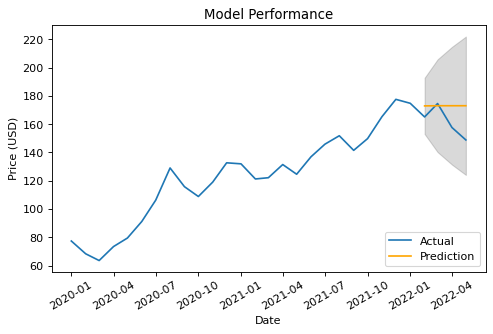

In [28]:
# Plot
plt.plot(data.Apple)
plt.plot(dp.price_predicted, color='orange')
plt.fill_between(dp.index, 
                 lower_int, 
                 upper_int, 
                 color='k', alpha=.15)


plt.title('Model Performance')
plt.legend(['Actual','Prediction'], loc='lower right')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('Price (USD)')
plt.show()

In [29]:
# import evaluation matrices
from sklearn.metrics import mean_absolute_error

# Evaluate the model
print('ARIMA MAE = ', mean_absolute_error(dp.price_actual, dp.price_predicted))

ARIMA MAE =  12.246732448885595


# Bivariate - Using the exogenous variable - **'TexasIns'**

In [30]:
# Bivariate analysis - We will use both 'Apple' and 'TexasIns' variables. 
# Training data - January 2020 to January 2022
# Testing data - February 2022 - May 2022
dfx = data.iloc[0:25,0:3]

In [31]:
dfx

,Apple,TexasIns
Date,,
2020-01-01,77.38,120.65
2020-02-01,68.34,114.14
2020-03-01,63.57,99.93
2020-04-01,73.45,116.07
2020-05-01,79.49,118.74
2020-06-01,91.20,126.97
2020-07-01,106.26,127.55
2020-08-01,129.04,142.15
2020-09-01,115.81,142.79


In [32]:
# 1,1,1 ARIMAX Model with exogenous variable
model2 = ARIMA(dfx.Apple, exog=dfx.TexasIns, order=(1,1,1))
arimax = model2.fit()
print(arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                  Apple   No. Observations:                   25
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -88.781
Date:                Mon, 03 Apr 2023   AIC                            185.562
Time:                        18:37:26   BIC                            190.274
Sample:                    01-01-2020   HQIC                           186.812
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TexasIns       0.3312      0.273      1.212      0.226      -0.205       0.867
ar.L1         -0.0947      0.922     -0.103      0.918      -1.901       1.712
ma.L1          0.3252      0.911      0.357      0.7

C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [33]:
# Forecast
forecast = arimax.get_forecast(4)
ypred = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)


ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [35]:
# we have the values
data.TexasIns.iloc[25:]

Date
2022-02-01    169.99
2022-03-01    183.48
2022-04-01    170.25
2022-05-01    176.76
Name: TexasIns, dtype: float64

In [36]:
ex = data.TexasIns.iloc[25:].values
ex

array([169.99, 183.48, 170.25, 176.76])

In [37]:
# Forecast
forecast = arimax.get_forecast(4, exog=ex)
ypred = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

In [38]:
# creating a new Dataframe dp with the prediction values.
Year = pd.Series(['2022-02-01', '2022-03-01', '2022-04-01','2022-05-01'])
price_actual = pd.Series(data.Apple[25:].values)
price_predicted = pd.Series(ypred.values) 
lower_int = pd.Series(conf_int['lower Apple'].values)
upper_int = upper_series = pd.Series(conf_int['upper Apple'].values)


dpx = pd.DataFrame([Date, price_actual, lower_int, price_predicted, upper_int], index =['Date','price_actual', 'lower_int','price_predicted','upper_int' ]).T
dpx = dpx.set_index('Date')
dpx.index = pd.to_datetime(dpx.index)
dpx

,price_actual,lower_int,price_predicted,upper_int
Date,,,,
2022-02-01,165.12,151.745453,170.888693,190.031934
2022-03-01,174.61,145.073799,175.426575,205.779352
2022-04-01,157.65,132.873196,171.038709,209.204222
2022-05-01,148.84,128.543676,173.19516,217.846645


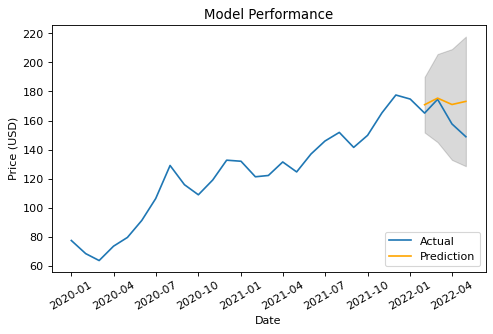

In [39]:
# Plot
plt.plot(data.Apple)
plt.plot(dpx.price_predicted, color='orange')
plt.fill_between(dpx.index, 
                 lower_int, 
                 upper_int, 
                 color='k', alpha=.15)
plt.title('Model Performance')
plt.legend(['Actual','Prediction'], loc='lower right')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('Price (USD)')
plt.show()

In [40]:
# import evaluation matrices
from sklearn.metrics import mean_absolute_error

# Evaluate the model
print('SARIMAX MAE = ', mean_absolute_error(dpx.price_actual, dpx.price_predicted))

SARIMAX MAE =  11.082284569302907


References:<br>
* https://www.machinelearningplus.com/time-series/time-series-analysis-python/<br>
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
